In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import warnings

# Filter out DeprecationWarnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Mounted at /content/drive


In [ ]:
!pip install nnunetv2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.1/184.1 kB 4.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.5/39.5 MB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 91.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.4/96.4 kB 3.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
 

In [ ]:
import nibabel as nib
import numpy as np
import os
import pickle
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import zipfile
import pathlib
import shutil
import json
from PIL import Image
from skimage import measure

In [ ]:
def extract_zip_and_prepare_folders():
  z = zipfile.ZipFile('/content/drive/MyDrive/archive.zip')
  z.extractall()

extract_zip_and_prepare_folders()

In [ ]:
dataset_dir = '/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
patients_folders = [dir for dir in os.listdir(dataset_dir) if not dir.endswith('csv')]

dataset_val_dir = '/content/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'
patients_folders_vals = [dir for dir in os.listdir(dataset_val_dir) if not dir.endswith('csv')]

In [ ]:
patients_folders.sort()
patients_folders_vals.sort()

In [ ]:
print(patients_folders)

['BraTS20_Training_001', 'BraTS20_Training_002', 'BraTS20_Training_003', 'BraTS20_Training_004', 'BraTS20_Training_005', 'BraTS20_Training_006', 'BraTS20_Training_007', 'BraTS20_Training_008', 'BraTS20_Training_009', 'BraTS20_Training_010', 'BraTS20_Training_011', 'BraTS20_Training_012', 'BraTS20_Training_013', 'BraTS20_Training_014', 'BraTS20_Training_015', 'BraTS20_Training_016', 'BraTS20_Training_017', 'BraTS20_Training_018', 'BraTS20_Training_019', 'BraTS20_Training_020', 'BraTS20_Training_021', 'BraTS20_Training_022', 'BraTS20_Training_023', 'BraTS20_Training_024', 'BraTS20_Training_025', 'BraTS20_Training_026', 'BraTS20_Training_027', 'BraTS20_Training_028', 'BraTS20_Training_029', 'BraTS20_Training_030', 'BraTS20_Training_031', 'BraTS20_Training_032', 'BraTS20_Training_033', 'BraTS20_Training_034', 'BraTS20_Training_035', 'BraTS20_Training_036', 'BraTS20_Training_037', 'BraTS20_Training_038', 'BraTS20_Training_039', 'BraTS20_Training_040', 'BraTS20_Training_041', 'BraTS20_Traini

In [ ]:
here = pathlib.Path('.').resolve()

nnUNet_raw = here.joinpath('nnUNet_raw')
nnUNet_preprocessed = here.joinpath('nnUNet_preprocessed')
nnUNet_results = here.joinpath('nnUNet_results')

nnUNet_raw.mkdir(exist_ok=True, parents=True)

In [ ]:
os.environ["nnUNet_raw"] = str(nnUNet_raw)
os.environ["nnUNet_preprocessed"] = str(nnUNet_preprocessed)
os.environ["nnUNet_results"] = str(nnUNet_results)

In [ ]:
# Create folders
os.mkdir("/content/nnUNet_raw/Dataset001_BrainTumour")
os.mkdir("/content/nnUNet_raw/Dataset001_BrainTumour/imagesTr")
os.mkdir("/content/nnUNet_raw/Dataset001_BrainTumour/imagesTs")
os.mkdir("/content/nnUNet_raw/Dataset001_BrainTumour/labelsTr")



In [ ]:
shutil.rmtree("/content/nnUNet_raw")

In [ ]:
SRC_DIR_TR = "/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
SRC_DIR_TS = "/content/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData"

TARGET_DIR_TR= "/content/nnUNet_raw/Dataset001_BrainTumour/imagesTr"
TARGET_DIR_TS= "/content/nnUNet_raw/Dataset001_BrainTumour/imagesTs"
TARGET_DIR_LABELS= "/content/nnUNet_raw/Dataset001_BrainTumour/labelsTr"

In [ ]:
count = 1
training = []
modalities = {"flair":"0000","t1":"0001","t1ce":"0002","t2":"0003"}
for patient in patients_folders[:60]:
    label_name = f"BRATS_{count :03d}.nii"
    for modality in modalities.keys():
      img_name = f"BRATS_{count :03d}_{modalities[modality]}.nii"
      shutil.copy(os.path.join(SRC_DIR_TR, patient, patient+f"_{modality}" + ".nii"), os.path.join(TARGET_DIR_TR,img_name))
      training.append({"image":f"./imagesTr/{img_name}", "label":f"./labelsTr/{label_name}"})

    shutil.copy(os.path.join(SRC_DIR_TR, patient, patient+f"_seg" + ".nii"), os.path.join(TARGET_DIR_LABELS,label_name))

    count += 1

In [ ]:
test = []
count = 1
for patient in patients_folders_vals[:30]:
    for modality in modalities.keys():
      img_name = f"BRATS_{count :03d}_{modalities[modality]}.nii"
      shutil.copy(os.path.join(SRC_DIR_TS, patient, patient+f"_{modality}" + ".nii"), os.path.join(TARGET_DIR_TS,img_name))
    test.append({"image":f"./imagesTs/{img_name}"})
    count += 1

In [ ]:
print(training)
print(test)

[{'image': './imagesTr/BRATS_001_0000.nii', 'label': './labelsTr/BRATS_001.nii'}, {'image': './imagesTr/BRATS_001_0001.nii', 'label': './labelsTr/BRATS_001.nii'}, {'image': './imagesTr/BRATS_001_0002.nii', 'label': './labelsTr/BRATS_001.nii'}, {'image': './imagesTr/BRATS_001_0003.nii', 'label': './labelsTr/BRATS_001.nii'}, {'image': './imagesTr/BRATS_002_0000.nii', 'label': './labelsTr/BRATS_002.nii'}, {'image': './imagesTr/BRATS_002_0001.nii', 'label': './labelsTr/BRATS_002.nii'}, {'image': './imagesTr/BRATS_002_0002.nii', 'label': './labelsTr/BRATS_002.nii'}, {'image': './imagesTr/BRATS_002_0003.nii', 'label': './labelsTr/BRATS_002.nii'}, {'image': './imagesTr/BRATS_003_0000.nii', 'label': './labelsTr/BRATS_003.nii'}, {'image': './imagesTr/BRATS_003_0001.nii', 'label': './labelsTr/BRATS_003.nii'}, {'image': './imagesTr/BRATS_003_0002.nii', 'label': './labelsTr/BRATS_003.nii'}, {'image': './imagesTr/BRATS_003_0003.nii', 'label': './labelsTr/BRATS_003.nii'}, {'image': './imagesTr/BRATS

In [ ]:
import gzip

def compress_nii_files(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".nii"):
                nii_path = os.path.join(root, file)
                gz_path = nii_path + ".gz"
                with open(nii_path, 'rb') as f_in:
                    with gzip.open(gz_path, 'wb') as f_out:
                        shutil.copyfileobj(f_in, f_out)
                os.remove(nii_path)  # Orijinal .nii dosyasını kaldırmak isterseniz bu satırı ekleyin

# Eğitim ve test dizinlerini sıkıştırma
compress_nii_files('/content/nnUNet_raw/Dataset001_BrainTumour/imagesTr')
compress_nii_files('/content/nnUNet_raw/Dataset001_BrainTumour/labelsTr')
compress_nii_files('/content/nnUNet_raw/Dataset001_BrainTumour/imagesTs')

In [ ]:
import SimpleITK as sitk

def copy_BraTS_segmentation_and_convert_labels_to_nnUNet(in_file: str, out_file: str) -> None:
    # use this for segmentation only!!!
    # nnUNet wants the labels to be continuous. BraTS is 0, 1, 2, 4 -> we make that into 0, 1, 2, 3
    img = sitk.ReadImage(in_file)
    img_npy = sitk.GetArrayFromImage(img)

    uniques = np.unique(img_npy)
   # Round floating values to nearest integers
    seg_data_int = seg_data.round().astype(int)
    for u in uniques:
        print("U: ",u)
        if u not in [0, 1, 2, 3,4]:
            raise RuntimeError('unexpected label')

    seg_new = np.zeros_like(img_npy)
    seg_new[img_npy == 4] = 3
    seg_new[img_npy == 2] = 1
    seg_new[img_npy == 1] = 2
    img_corr = sitk.GetImageFromArray(seg_new)
    img_corr.CopyInformation(img)
    sitk.WriteImage(img_corr, out_file)


In [ ]:
def fix_labels(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".nii.gz"):
                file_path = os.path.join(root, file)
                # copy_BraTS_segmentation_and_convert_labels_to_nnUNet(file_path,file_path)
                img = nib.load(file_path)
                img_data = img.get_fdata()

                # Hatalı etiketleri düzeltme
                img_data[img_data == 4] = 3

                # Yeni etiketi kaydetme
                corrected_img = nib.Nifti1Image(img_data, img.affine, img.header)
                nib.save(corrected_img, file_path)
                print(f"Fixed labels in file: {file_path}")

# Eğitim etiketlerini düzeltme
# fix_labels('/content/nnUNet_raw/Dataset001_BrainTumour/imagesTr')
fix_labels('/content/nnUNet_raw/Dataset001_BrainTumour/labelsTr')
# fix_labels('/content/nnUNet_raw/Dataset001_BrainTumour/imagesTs')

Fixed labels in file: /content/nnUNet_raw/Dataset001_BrainTumour/labelsTr/BRATS_037.nii.gz
Fixed labels in file: /content/nnUNet_raw/Dataset001_BrainTumour/labelsTr/BRATS_026.nii.gz
Fixed labels in file: /content/nnUNet_raw/Dataset001_BrainTumour/labelsTr/BRATS_005.nii.gz
Fixed labels in file: /content/nnUNet_raw/Dataset001_BrainTumour/labelsTr/BRATS_057.nii.gz
Fixed labels in file: /content/nnUNet_raw/Dataset001_BrainTumour/labelsTr/BRATS_035.nii.gz
Fixed labels in file: /content/nnUNet_raw/Dataset001_BrainTumour/labelsTr/BRATS_034.nii.gz
Fixed labels in file: /content/nnUNet_raw/Dataset001_BrainTumour/labelsTr/BRATS_029.nii.gz
Fixed labels in file: /content/nnUNet_raw/Dataset001_BrainTumour/labelsTr/BRATS_007.nii.gz
Fixed labels in file: /content/nnUNet_raw/Dataset001_BrainTumour/labelsTr/BRATS_031.nii.gz
Fixed labels in file: /content/nnUNet_raw/Dataset001_BrainTumour/labelsTr/BRATS_043.nii.gz
Fixed labels in file: /content/nnUNet_raw/Dataset001_BrainTumour/labelsTr/BRATS_054.nii.gz

In [ ]:
from typing import Tuple

from batchgenerators.utilities.file_and_folder_operations import save_json, join


def generate_dataset_json(output_folder: str,
                          channel_names: dict,
                          labels: dict,
                          num_training_cases: int,
                          file_ending: str,
                          regions_class_order: Tuple[int, ...] = None,
                          dataset_name: str = None, reference: str = None, release: str = None, license: str = None,
                          description: str = None,
                          overwrite_image_reader_writer: str = None, **kwargs):
    """
    Generates a dataset.json file in the output folder

    channel_names:
        Channel names must map the index to the name of the channel, example:
        {
            0: 'T1',
            1: 'CT'
        }
        Note that the channel names may influence the normalization scheme!! Learn more in the documentation.

    labels:
        This will tell nnU-Net what labels to expect. Important: This will also determine whether you use region-based training or not.
        Example regular labels:
        {
            'background': 0,
            'left atrium': 1,
            'some other label': 2
        }
        Example region-based training:
        {
            'background': 0,
            'whole tumor': (1, 2, 3),
            'tumor core': (2, 3),
            'enhancing tumor': 3
        }

        Remember that nnU-Net expects consecutive values for labels! nnU-Net also expects 0 to be background!

    num_training_cases: is used to double check all cases are there!

    file_ending: needed for finding the files correctly. IMPORTANT! File endings must match between images and
    segmentations!

    dataset_name, reference, release, license, description: self-explanatory and not used by nnU-Net. Just for
    completeness and as a reminder that these would be great!

    overwrite_image_reader_writer: If you need a special IO class for your dataset you can derive it from
    BaseReaderWriter, place it into nnunet.imageio and reference it here by name

    kwargs: whatever you put here will be placed in the dataset.json as well

    """
    has_regions: bool = any([isinstance(i, (tuple, list)) and len(i) > 1 for i in labels.values()])
    if has_regions:
        assert regions_class_order is not None, f"You have defined regions but regions_class_order is not set. " \
                                                f"You need that."
    # channel names need strings as keys
    keys = list(channel_names.keys())
    for k in keys:
        if not isinstance(k, str):
            channel_names[str(k)] = channel_names[k]
            del channel_names[k]

    # labels need ints as values
    for l in labels.keys():
        value = labels[l]
        if isinstance(value, (tuple, list)):
            value = tuple([int(i) for i in value])
            labels[l] = value
        else:
            labels[l] = int(labels[l])

    dataset_json = {
        'channel_names': channel_names,  # previously this was called 'modality'. I didn't like this so this is
        # channel_names now. Live with it.
        'labels': labels,
        'numTraining': num_training_cases,
        'file_ending': file_ending,
    }

    if dataset_name is not None:
        dataset_json['name'] = dataset_name
    if reference is not None:
        dataset_json['reference'] = reference
    if release is not None:
        dataset_json['release'] = release
    if license is not None:
        dataset_json['licence'] = license
    if description is not None:
        dataset_json['description'] = description
    if overwrite_image_reader_writer is not None:
        dataset_json['overwrite_image_reader_writer'] = overwrite_image_reader_writer
    if regions_class_order is not None:
        dataset_json['regions_class_order'] = regions_class_order

    dataset_json.update(kwargs)

    save_json(dataset_json, join(output_folder, 'dataset.json'), sort_keys=False)

In [ ]:
channels= {
        "0": "FLAIR",
        "1": "T1",
        "2": "T1ce",
        "3": "T2"
    }
labels= {
    "background": 0,
    "whole_tumor": [1, 2, 3],
    "tumor_core": [2, 3],
    "enhancing_tumor": [3] # or [3]
}
region =  [1, 2, 3]
args={
    "train":training,
    "test":test,
    "description": "Brain Tumor Segmentation 2020",
    "reference": "https://www.med.upenn.edu/cbica/brats2020/",
    "licence": "see https://www.med.upenn.edu/sbia/brats2020/data.html",
    "release": "0",
    }
generate_dataset_json("/content/nnUNet_raw/Dataset001_BrainTumour",channels, labels, 60, ".nii.gz",region, "dataset_name=""BraTS2020",**args)

In [ ]:
!nnUNetv2_plan_and_preprocess -d 1 --verify_dataset_integrity

Fingerprint extraction...
Dataset001_BrainTumour
Using <class 'nnunetv2.imageio.simpleitk_reader_writer.SimpleITKIO'> as reader/writer

####################
verify_dataset_integrity Done. 
If you didn't see any error messages then your dataset is most likely OK!
####################

Using <class 'nnunetv2.imageio.simpleitk_reader_writer.SimpleITKIO'> as reader/writer
100% 60/60 [00:15<00:00,  3.94it/s]
Experiment planning...

############################
INFO: You are using the old nnU-Net default planner. We have updated our recommendations. Please consider using those instead! Read more here: https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/resenc_presets.md
############################

Dropping 3d_lowres config because the image size difference to 3d_fullres is too small. 3d_fullres: [140.  172.  135.5], 3d_lowres: [140, 172, 136]
2D U-Net configuration:
{'data_identifier': 'nnUNetPlans_2d', 'preprocessor_name': 'DefaultPreprocessor', 'batch_size': 105, 'patch_size': (

In [ ]:
import torch

from nnunetv2.training.nnUNetTrainer.nnUNetTrainer import nnUNetTrainer


class nnUNetTrainer_5epochs(nnUNetTrainer):
    def __init__(self, plans: dict, configuration: str, fold: int, dataset_json: dict, unpack_dataset: bool = True,
                 device: torch.device = torch.device('cuda')):
        """used for debugging plans etc"""
        super().__init__(plans, configuration, fold, dataset_json, unpack_dataset, device)
        self.num_epochs = 5


class nnUNetTrainer_1epoch(nnUNetTrainer):
    def __init__(self, plans: dict, configuration: str, fold: int, dataset_json: dict, unpack_dataset: bool = True,
                 device: torch.device = torch.device('cuda')):
        """used for debugging plans etc"""
        super().__init__(plans, configuration, fold, dataset_json, unpack_dataset, device)
        self.num_epochs = 1


class nnUNetTrainer_10epochs(nnUNetTrainer):
    def __init__(self, plans: dict, configuration: str, fold: int, dataset_json: dict, unpack_dataset: bool = True,
                 device: torch.device = torch.device('cuda')):
        """used for debugging plans etc"""
        super().__init__(plans, configuration, fold, dataset_json, unpack_dataset, device)
        self.num_epochs = 10


In [ ]:
plans = json.load(open("/content/nnUNet_preprocessed/Dataset001_BrainTumour/nnUNetPlans.json"))
dataset_json = json.load(open("/content/nnUNet_preprocessed/Dataset001_BrainTumour/dataset.json"))

In [ ]:
nnunet= nnUNetTrainer_5epochs(plans=plans,configuration="3d_fullres",fold=0,dataset_json=dataset_json)

nnunet.run_training()

Using device: cuda:0

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

2024-06-25 18:42:46.761074: do_dummy_2d_data_aug: False
2024-06-25 18:42:46.762915: Using splits from existing split file: /content/nnUNet_preprocessed/Dataset001_BrainTumour/splits_final.json
2024-06-25 18:42:46.764380: The split file contains 5 splits.
2024-06-25 18:42:46.764527: Desired fold for training: 0
2024-06-25 18:42:46.765382: This split has 48 training and 12 validation cases.
using pin_memory on device 0
using pin_memory on device 0
2024-06-25 18:42:59.886303: Using torch.compile...

This is the configuration used by this training:
Configuration name: 3d_fu

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


2024-06-25 18:43:00.909031: unpacking done...
2024-06-25 18:43:00.915776: Unable to plot network architecture: nnUNet_compile is enabled!
2024-06-25 18:43:00.971524: 
2024-06-25 18:43:00.972855: Epoch 0
2024-06-25 18:43:00.973570: Current learning rate: 0.01
2024-06-25 18:49:31.727226: train_loss -0.34
2024-06-25 18:49:31.729213: val_loss -0.6162
2024-06-25 18:49:31.730548: Pseudo dice [0.7868, 0.7411, 0.7588]
2024-06-25 18:49:31.731823: Epoch time: 390.76 s
2024-06-25 18:49:31.732873: Yayy! New best EMA pseudo Dice: 0.7622
2024-06-25 18:49:34.087759: 
2024-06-25 18:49:34.088046: Epoch 1
2024-06-25 18:49:34.089707: Current learning rate: 0.00818
2024-06-25 18:55:22.650487: train_loss -0.6806
2024-06-25 18:55:22.651371: val_loss -0.7225
2024-06-25 18:55:22.662275: Pseudo dice [0.8709, 0.8134, 0.8158]
2024-06-25 18:55:22.667738: Epoch time: 348.56 s
2024-06-25 18:55:22.668708: Yayy! New best EMA pseudo Dice: 0.7694
2024-06-25 18:55:26.961860: 
2024-06-25 18:55:26.962923: Epoch 2
2024-06-

In [ ]:
!nnUNetv2_train 1 3d_fullres 0


/bin/bash: line 1: nnUNetTrainer_1epoch: command not found


In [ ]:
!nnUNetv2_find_best_configuration Dataset001_BrainTumour -c 3d_fullres -h

usage: nnUNetv2_find_best_configuration [-h] [-p P [P ...]] [-c C [C ...]] [-tr TR [TR ...]]
                                        [-np NP] [-f F [F ...]] [--disable_ensembling]
                                        [--no_overwrite]
                                        dataset_name_or_id

positional arguments:
  dataset_name_or_id    Dataset Name or id

options:
  -h, --help            show this help message and exit
  -p P [P ...]          List of plan identifiers. Default: nnUNetPlans
  -c C [C ...]          List of configurations. Default: ['2d', '3d_fullres', '3d_lowres',
                        '3d_cascade_fullres']
  -tr TR [TR ...]       List of trainers. Default: nnUNetTrainer
  -np NP                Number of processes to use for ensembling, postprocessing etc
  -f F [F ...]          Folds to use. Default: 0 1 2 3 4
  --disable_ensembling  Set this flag to disable ensembling
  --no_overwrite        If set we will not overwrite already ensembled files etc. May speed up
 

In [ ]:
!nnUNetv2_predict -i /content/nnUNet_raw/Dataset001_BrainTumour/imagesTs -o /content/predictions -d 1 -c 3d_fullres --save_probabilities -f 0



#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

There are 30 cases in the source folder
I am process 0 out of 1 (max process ID is 0, we start counting with 0!)
There are 30 cases that I would like to predict

Predicting BRATS_001:
perform_everything_on_device: True
100% 8/8 [00:03<00:00,  2.60it/s]
sending off prediction to background worker for resampling and export
done with BRATS_001

Predicting BRATS_002:
perform_everything_on_device: True
100% 8/8 [00:01<00:00,  4.70it/s]
sending off prediction to background worker for resampling and export
done with BRATS_002

Predicting BRATS_003:
perform_everything_on_device: True
100% 8/8 [00:0

In [ ]:
import SimpleITK as sitk
import os
import matplotlib.pyplot as plt

def show(path):
    # NIfTI dosyasını yükleme
    img = sitk.ReadImage(os.path.join("/content/predictions/", path))
    img_array = sitk.GetArrayFromImage(img)

    num_slices = img_array.shape[0]
    num_cols = 5  # Her satırda gösterilecek dilim sayısı
    num_rows = (num_slices + num_cols - 1) // num_cols  # Yeterli satır sayısını hesapla

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < num_slices:
            ax.imshow(img_array[i, :, :], cmap='gray')
            ax.axis('off')
        else:
            ax.axis('off')  # Eksik olan dilimler için eksik ekranı kapat

    fig.suptitle('NIfTI Dosya Dilimleri', fontsize=16)
    plt.tight_layout(pad=0.3)  # Alt grafikler arasındaki boşluğu manuel olarak ayarla
    plt.show()

show("BRATS_003.nii.gz")


In [ ]:
from nnunetv2.paths import nnUNet_results, nnUNet_raw
import torch
from batchgenerators.utilities.file_and_folder_operations import join
from nnunetv2.inference.predict_from_raw_data import nnUNetPredictor

    # instantiate the nnUNetPredictor
predictor = nnUNetPredictor(
        tile_step_size=0.5,
        use_gaussian=True,
        use_mirroring=True,
        perform_everything_on_device=True,
        device=torch.device('cuda', 0),
        verbose=False,
        verbose_preprocessing=False,
        allow_tqdm=True
    )
    # initializes the network architecture, loads the checkpoint
predictor.initialize_from_trained_model_folder(
        join(nnUNet_results, 'Dataset001_BrainTumour/nnUNetTrainer__nnUNetPlans__3d_fullres'),
        use_folds=(0,),
        checkpoint_name='checkpoint_final.pth',
    )
    # variant 1: give input and output folders
predictor.predict_from_files(join(nnUNet_raw, 'Dataset001_BrainTumour/imagesTs'),
                                 join(nnUNet_raw, 'Dataset001_BrainTumour/imagesTs_predfullres'),
                                 save_probabilities=False, overwrite=False,
                                 num_processes_preprocessing=2, num_processes_segmentation_export=2,
                                 folder_with_segs_from_prev_stage=None, num_parts=1, part_id=0)

There are 30 cases in the source folder
I am process 0 out of 1 (max process ID is 0, we start counting with 0!)
There are 30 cases that I would like to predict
overwrite was set to False, so I am only working on cases that haven't been predicted yet. That's 30 cases.

Predicting BRATS_001:
perform_everything_on_device: True


100%|██████████| 8/8 [00:02<00:00,  3.17it/s]


sending off prediction to background worker for resampling and export
done with BRATS_001

Predicting BRATS_002:
perform_everything_on_device: True


100%|██████████| 8/8 [00:01<00:00,  4.69it/s]


sending off prediction to background worker for resampling and export
done with BRATS_002

Predicting BRATS_003:
perform_everything_on_device: True


100%|██████████| 8/8 [00:01<00:00,  4.69it/s]


sending off prediction to background worker for resampling and export
done with BRATS_003

Predicting BRATS_004:
perform_everything_on_device: True


100%|██████████| 8/8 [00:01<00:00,  4.69it/s]


sending off prediction to background worker for resampling and export
done with BRATS_004

Predicting BRATS_005:
perform_everything_on_device: True


100%|██████████| 8/8 [00:01<00:00,  4.69it/s]


sending off prediction to background worker for resampling and export
done with BRATS_005

Predicting BRATS_006:
perform_everything_on_device: True


100%|██████████| 8/8 [00:01<00:00,  4.69it/s]


sending off prediction to background worker for resampling and export
done with BRATS_006

Predicting BRATS_007:
perform_everything_on_device: True


100%|██████████| 8/8 [00:01<00:00,  4.69it/s]


sending off prediction to background worker for resampling and export
done with BRATS_007

Predicting BRATS_008:
perform_everything_on_device: True


100%|██████████| 8/8 [00:01<00:00,  4.69it/s]


sending off prediction to background worker for resampling and export
done with BRATS_008

Predicting BRATS_009:
perform_everything_on_device: True


100%|██████████| 8/8 [00:01<00:00,  4.69it/s]


sending off prediction to background worker for resampling and export
done with BRATS_009

Predicting BRATS_010:
perform_everything_on_device: True


100%|██████████| 8/8 [00:01<00:00,  4.69it/s]


sending off prediction to background worker for resampling and export
done with BRATS_010

Predicting BRATS_011:
perform_everything_on_device: True


100%|██████████| 4/4 [00:00<00:00,  5.01it/s]


sending off prediction to background worker for resampling and export
done with BRATS_011

Predicting BRATS_012:
perform_everything_on_device: True


100%|██████████| 8/8 [00:01<00:00,  4.69it/s]


sending off prediction to background worker for resampling and export
done with BRATS_012

Predicting BRATS_013:
perform_everything_on_device: True


100%|██████████| 8/8 [00:01<00:00,  4.69it/s]


sending off prediction to background worker for resampling and export
done with BRATS_013

Predicting BRATS_014:
perform_everything_on_device: True


100%|██████████| 8/8 [00:01<00:00,  4.69it/s]


sending off prediction to background worker for resampling and export
done with BRATS_014

Predicting BRATS_015:
perform_everything_on_device: True


100%|██████████| 8/8 [00:01<00:00,  4.68it/s]


sending off prediction to background worker for resampling and export
done with BRATS_015

Predicting BRATS_016:
perform_everything_on_device: True


100%|██████████| 8/8 [00:01<00:00,  4.69it/s]


sending off prediction to background worker for resampling and export
done with BRATS_016

Predicting BRATS_017:
perform_everything_on_device: True


100%|██████████| 8/8 [00:01<00:00,  4.69it/s]


sending off prediction to background worker for resampling and export
done with BRATS_017

Predicting BRATS_018:
perform_everything_on_device: True


100%|██████████| 8/8 [00:01<00:00,  4.69it/s]


sending off prediction to background worker for resampling and export
done with BRATS_018

Predicting BRATS_019:
perform_everything_on_device: True


100%|██████████| 4/4 [00:00<00:00,  5.01it/s]


sending off prediction to background worker for resampling and export
done with BRATS_019

Predicting BRATS_020:
perform_everything_on_device: True


100%|██████████| 8/8 [00:01<00:00,  4.69it/s]


sending off prediction to background worker for resampling and export
done with BRATS_020

Predicting BRATS_021:
perform_everything_on_device: True


100%|██████████| 8/8 [00:01<00:00,  4.69it/s]


sending off prediction to background worker for resampling and export
done with BRATS_021

Predicting BRATS_022:
perform_everything_on_device: True


100%|██████████| 8/8 [00:01<00:00,  4.69it/s]


sending off prediction to background worker for resampling and export
done with BRATS_022

Predicting BRATS_023:
perform_everything_on_device: True


100%|██████████| 8/8 [00:01<00:00,  4.68it/s]


sending off prediction to background worker for resampling and export
done with BRATS_023

Predicting BRATS_024:
perform_everything_on_device: True


100%|██████████| 8/8 [00:01<00:00,  4.69it/s]


sending off prediction to background worker for resampling and export
done with BRATS_024

Predicting BRATS_025:
perform_everything_on_device: True


100%|██████████| 8/8 [00:01<00:00,  4.49it/s]


sending off prediction to background worker for resampling and export
done with BRATS_025

Predicting BRATS_026:
perform_everything_on_device: True


100%|██████████| 4/4 [00:00<00:00,  5.01it/s]


sending off prediction to background worker for resampling and export
done with BRATS_026

Predicting BRATS_027:
perform_everything_on_device: True


100%|██████████| 8/8 [00:01<00:00,  4.68it/s]


sending off prediction to background worker for resampling and export
done with BRATS_027

Predicting BRATS_028:
perform_everything_on_device: True


100%|██████████| 8/8 [00:01<00:00,  4.69it/s]


sending off prediction to background worker for resampling and export
done with BRATS_028

Predicting BRATS_029:
perform_everything_on_device: True


100%|██████████| 8/8 [00:01<00:00,  4.69it/s]


sending off prediction to background worker for resampling and export
done with BRATS_029

Predicting BRATS_030:
perform_everything_on_device: True


100%|██████████| 8/8 [00:01<00:00,  4.69it/s]


sending off prediction to background worker for resampling and export
done with BRATS_030


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [88]:
from nnunetv2.imageio.simpleitk_reader_writer import SimpleITKIO

img, props = SimpleITKIO().read_images([join(nnUNet_raw, 'Dataset001_BrainTumour/imagesTs/BRATS_001_0000.nii.gz'),join(nnUNet_raw, 'Dataset001_BrainTumour/imagesTs/BRATS_001_0001.nii.gz'),join(nnUNet_raw, 'Dataset001_BrainTumour/imagesTs/BRATS_001_0002.nii.gz'),join(nnUNet_raw, 'Dataset001_BrainTumour/imagesTs/BRATS_001_0003.nii.gz')])
img2, props2 = SimpleITKIO().read_images([join(nnUNet_raw, 'Dataset001_BrainTumour/imagesTs/BRATS_002_0000.nii.gz'),join(nnUNet_raw, 'Dataset001_BrainTumour/imagesTs/BRATS_002_0001.nii.gz'),join(nnUNet_raw, 'Dataset001_BrainTumour/imagesTs/BRATS_002_0002.nii.gz'),join(nnUNet_raw, 'Dataset001_BrainTumour/imagesTs/BRATS_002_0003.nii.gz')])
img3, props3 = SimpleITKIO().read_images([join(nnUNet_raw, 'Dataset001_BrainTumour/imagesTs/BRATS_003_0000.nii.gz'),join(nnUNet_raw, 'Dataset001_BrainTumour/imagesTs/BRATS_003_0001.nii.gz'),join(nnUNet_raw, 'Dataset001_BrainTumour/imagesTs/BRATS_003_0002.nii.gz'),join(nnUNet_raw, 'Dataset001_BrainTumour/imagesTs/BRATS_003_0003.nii.gz')])
img4, props4 = SimpleITKIO().read_images([join(nnUNet_raw, 'Dataset001_BrainTumour/imagesTs/BRATS_004_0000.nii.gz'),join(nnUNet_raw, 'Dataset001_BrainTumour/imagesTs/BRATS_004_0001.nii.gz'),join(nnUNet_raw, 'Dataset001_BrainTumour/imagesTs/BRATS_004_0002.nii.gz'),join(nnUNet_raw, 'Dataset001_BrainTumour/imagesTs/BRATS_004_0003.nii.gz')])
img10, props10 = SimpleITKIO().read_images([join(nnUNet_raw, 'Dataset001_BrainTumour/imagesTs/BRATS_010_0000.nii.gz'),join(nnUNet_raw, 'Dataset001_BrainTumour/imagesTs/BRATS_010_0001.nii.gz'),join(nnUNet_raw, 'Dataset001_BrainTumour/imagesTs/BRATS_010_0002.nii.gz'),join(nnUNet_raw, 'Dataset001_BrainTumour/imagesTs/BRATS_010_0003.nii.gz')])
img20, props20 = SimpleITKIO().read_images([join(nnUNet_raw, 'Dataset001_BrainTumour/imagesTs/BRATS_020_0000.nii.gz'),join(nnUNet_raw, 'Dataset001_BrainTumour/imagesTs/BRATS_020_0001.nii.gz'),join(nnUNet_raw, 'Dataset001_BrainTumour/imagesTs/BRATS_020_0002.nii.gz'),join(nnUNet_raw, 'Dataset001_BrainTumour/imagesTs/BRATS_020_0003.nii.gz')])
img25, props25 = SimpleITKIO().read_images([join(nnUNet_raw, 'Dataset001_BrainTumour/imagesTs/BRATS_025_0000.nii.gz'),join(nnUNet_raw, 'Dataset001_BrainTumour/imagesTs/BRATS_025_0001.nii.gz'),join(nnUNet_raw, 'Dataset001_BrainTumour/imagesTs/BRATS_025_0002.nii.gz'),join(nnUNet_raw, 'Dataset001_BrainTumour/imagesTs/BRATS_025_0003.nii.gz')])


    # we do not set output files so that the segmentations will be returned. You can of course also specify output
    # files instead (no return value on that case)
ret = predictor.predict_from_list_of_npy_arrays([img, img2, img3, img4,img10,img20,img25],
                                                    None,
                                                    [props, props2, props3, props4,props10,props20,props25],
                                                    None, 2, save_probabilities=False,
                                                    num_processes_segmentation_export=2)


Predicting image of shape torch.Size([4, 140, 186, 133]):
perform_everything_on_device: True


100%|██████████| 8/8 [00:01<00:00,  4.61it/s]


sending off prediction to background worker for resampling

Done with image of shape torch.Size([4, 140, 186, 133]):

Predicting image of shape torch.Size([4, 142, 190, 143]):
perform_everything_on_device: True


100%|██████████| 8/8 [00:01<00:00,  4.68it/s]


sending off prediction to background worker for resampling

Done with image of shape torch.Size([4, 142, 190, 143]):

Predicting image of shape torch.Size([4, 140, 165, 125]):
perform_everything_on_device: True


100%|██████████| 8/8 [00:01<00:00,  4.68it/s]


sending off prediction to background worker for resampling

Done with image of shape torch.Size([4, 140, 165, 125]):

Predicting image of shape torch.Size([4, 138, 180, 132]):
perform_everything_on_device: True


100%|██████████| 8/8 [00:01<00:00,  4.68it/s]


sending off prediction to background worker for resampling

Done with image of shape torch.Size([4, 138, 180, 132]):

Predicting image of shape torch.Size([4, 146, 176, 135]):
perform_everything_on_device: True


100%|██████████| 8/8 [00:01<00:00,  4.38it/s]


sending off prediction to background worker for resampling

Done with image of shape torch.Size([4, 146, 176, 135]):

Predicting image of shape torch.Size([4, 139, 168, 125]):
perform_everything_on_device: True


100%|██████████| 8/8 [00:01<00:00,  4.68it/s]


sending off prediction to background worker for resampling

Done with image of shape torch.Size([4, 139, 168, 125]):

Predicting image of shape torch.Size([4, 135, 178, 138]):
perform_everything_on_device: True


100%|██████████| 8/8 [00:01<00:00,  4.69it/s]


sending off prediction to background worker for resampling

Done with image of shape torch.Size([4, 135, 178, 138]):


0


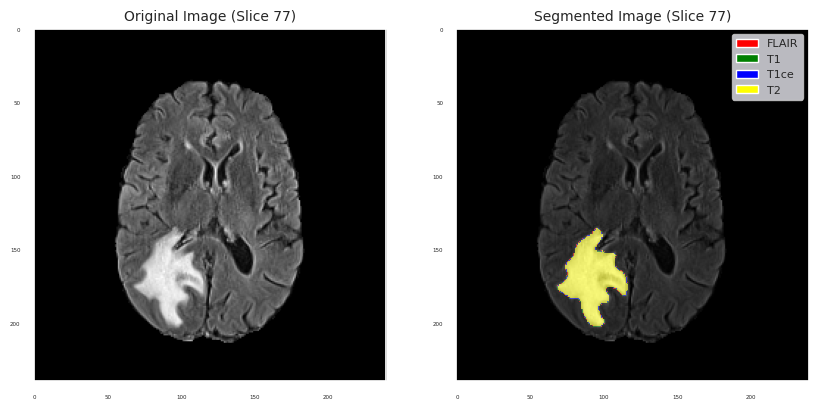

1


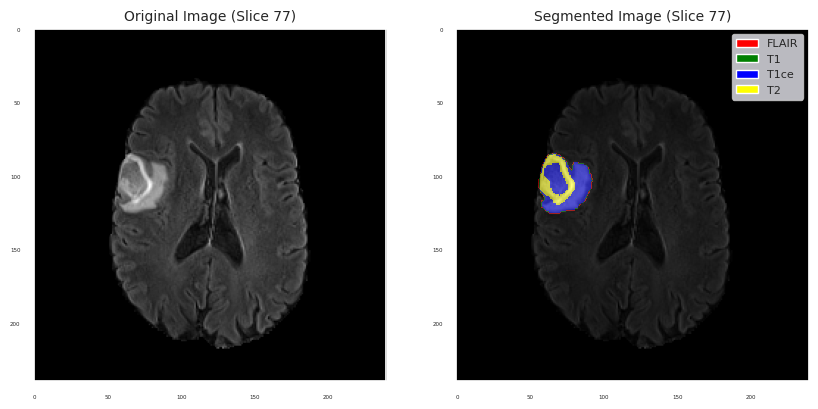

2


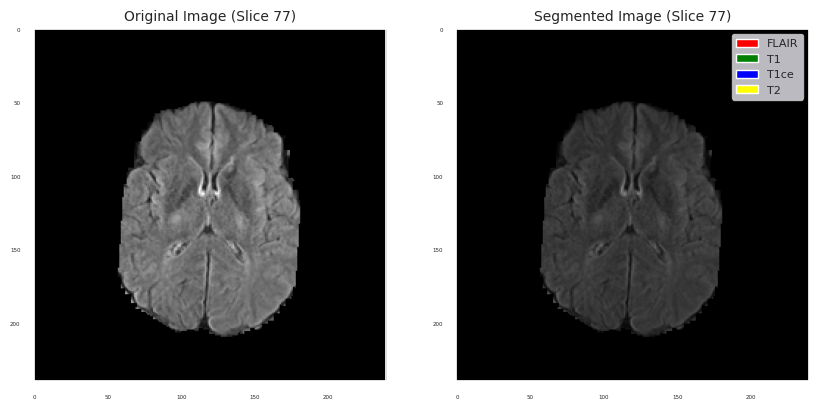

3


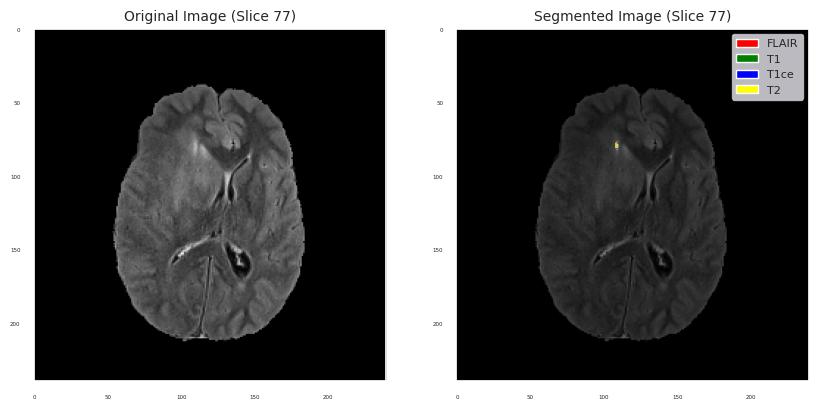

4


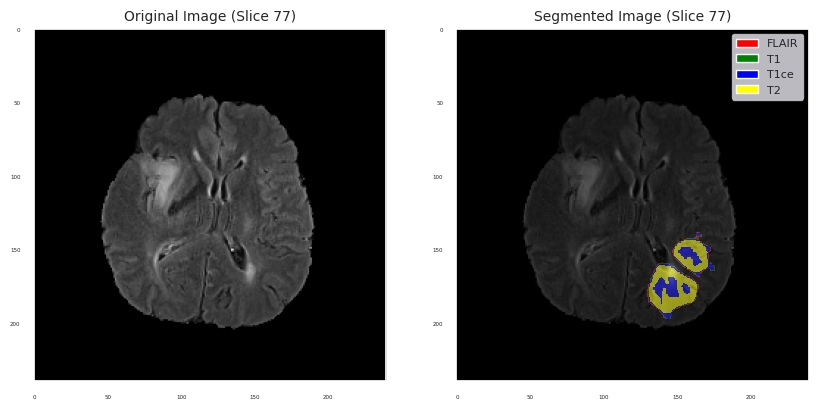

5


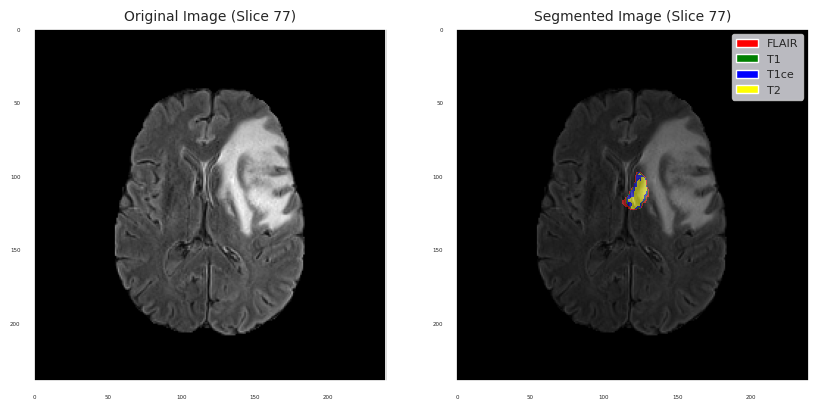

6


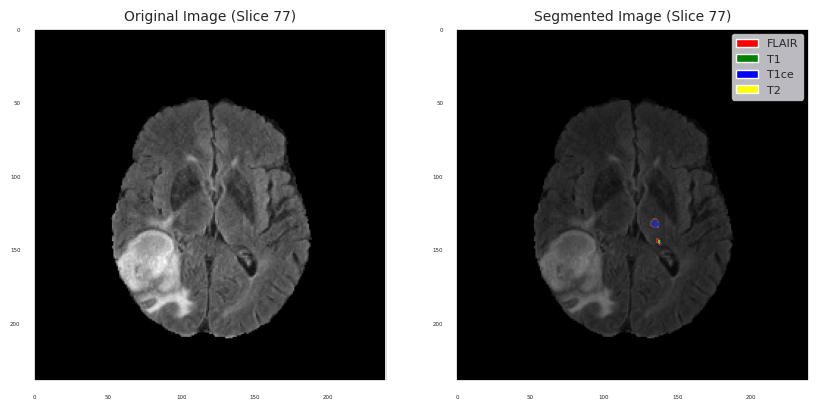

In [94]:
%matplotlib inline
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

cmap = ListedColormap(['black','red', 'green', 'blue','yellow'])  # 0: black, 1: red, 2: green, 3: blue

for i, seg_result_np in enumerate(ret): # seg_result is already a NumPy array
    # Get the original image for reference
    print(i)
    original_img = sitk.ReadImage(join(nnUNet_raw, f'Dataset001_BrainTumour/imagesTs/BRATS_{i+1 :03d}_0000.nii.gz'))
    original_img_np = sitk.GetArrayFromImage(original_img)
    # print(f"Original image shape: {original_img_np.shape}")
    # print(f"Segmentation shape: {seg_result_np.shape}")
    # print(f"Min/Max of original image: {original_img_np.min(), original_img_np.max()}")
    # print(f"Unique values in segmentation: {np.unique(seg_result_np)}")

    # Select a slice to display (e.g., middle slice)
    slice_idx = original_img_np.shape[0] // 2

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Display original image slice
    axes[0].imshow(original_img_np[slice_idx], cmap='gray')
    axes[0].set_title(f'Original Image (Slice {slice_idx})',fontsize=10)

    seg_result_np_norm = seg_result_np.astype(float) / seg_result_np.max()

    # Overlay segmentation on the original slice
    axes[1].imshow(original_img_np[slice_idx], cmap='gray')
    axes[1].imshow(seg_result_np_norm[slice_idx], alpha=0.5, cmap=cmap)  # Use custom colormap
    axes[1].set_title(f'Segmented Image (Slice {slice_idx})',fontsize=10)
    axes[0].tick_params(axis='both', labelsize=4)
    axes[1].tick_params(axis='both', labelsize=4)
    axes[0].grid(False)
    axes[1].grid(False)
    legend_elements = [Patch(facecolor=cmap(i+1), label=label) for i, label in enumerate(["FLAIR", "T1", "T1ce", "T2"])]
    plt.legend(handles=legend_elements, fontsize=8, loc='upper right')  # Font boyutunu ve konumunu ayarladık
    plt.rcParams.update({'font.size': 4})  # İstediğiniz yazı boyutunu ayarlayın (örnek: 8)
    plt.show()
    plt.close(fig)
